In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [93]:
data_hindi = pd.read_csv('/content/randomized_combined_dataset.csv')
data_hindi.dropna(inplace = True)
data_hindi.head(5)

,title,label
0,Senator Lee to endorse Republican presidential...,0
1,Factbox: What might be in Senate's mystery hea...,0
2,Bombshell Reports Confirm What We Already Bel...,1
3,ऐसा होगा हमारा भव्य राम मंदिर। आयोध्या में भव्...,1
4,IRANIAN NAVY FIRES WARNING SHOTS ON AND SEIZES...,1


In [94]:
#column = ['id']
#data_hindi = data_hindi.drop(columns='id')
input_array=np.array(data_hindi['title'])

data_hindi.head()

,title,label
0,Senator Lee to endorse Republican presidential...,0
1,Factbox: What might be in Senate's mystery hea...,0
2,Bombshell Reports Confirm What We Already Bel...,1
3,ऐसा होगा हमारा भव्य राम मंदिर। आयोध्या में भव्...,1
4,IRANIAN NAVY FIRES WARNING SHOTS ON AND SEIZES...,1


In [95]:
a=len(input_array)
p=int(a/30)

In [96]:
input_array[24].split()



['House',
 'Speaker',
 'backs',
 'probe',
 'of',
 'cyber',
 'threats',
 'on',
 'U.S.',
 'election',
 'process']

In [97]:
# stopwords
hindi =[
 'अत','अपना','अपनी','अपने','अभी','अंदर','आदि','आप','इत्यादि','इन','इनका','इन्हीं','इन्हें','इन्हों','इस','इसका','इसकी','इसके','इसमें',
'इसी','इसे','उन','उनका','उनकी','उनके','उनको','उन्हीं','उन्हें','उन्हों','उस','उसके','उसी','उसे','एक','एवं','एस','ऐसे','और','कई',
'कर','करता','करते','करना','करने','करें','कहते','कहा','का','काफ़ी','कि','कितना','किन्हें','किन्हों','किया','किर','किस','किसी','किसे','की',
'कुछ','कुल','के','को','कोई','कौन','कौन','बही','बहुत','बाद','बाला','बिलकुल','भी','भीतर','मगर','मानो','मे','में','यदि','यह','यहाँ','यही',
'या','यिह','ये','रखें','रहा','रहे','ऱ्वासा','लिए','लिये','लेकिन','व','वग़ैरह','वर्ग','वह','वहाँ','वहीं','वाले','वुह','वे','सकता','सकते','सबसे',
'सभी','साथ','साबुत','साभ','सारा','से','सो','संग','ही','हुआ','हुई','हुए','है','हैं','हो','होता','होती','होते','होना','होने']


In [98]:
import re
import nltk
# ltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
corpus = []
for i in range(0, p):
    review = input_array[i]
    review = review.split()
    ps = PorterStemmer()
    review = [ps.stem(word) for word in review if not word in set(hindi)]
    review = ' '.join(review)
    corpus.append(review)
corpus[:10]

['senat lee to endors republican presidenti candid cruz: report',
 "factbox: what might be in senate' mysteri healthcar bill",
 'bombshel report confirm what we alreadi believ about msnbc’ joe and mika (details)',
 'ऐसा होगा हमारा भव्य राम मंदिर। आयोध्या भव्य राम मंदिर मॉडल दर्शन।',
 'iranian navi fire warn shot on and seiz cargo ship; u.s. navi send destroy',
 'आंख कान दोनों खोलकर देखो सरकार देश भविष्य बेवश लाचार । एग्जाम गरीबों गांव विद्यार्थी परीक्षा नहीं दे पा बाढ़ बारिश कारण।',
 'podesta threaten tucker for expos the truth [video]',
 'indonesia group pinpoint suspect mass grave from 1965 massacr',
 'तूं बता हलवाई काम वाला कचरी फुलौरी समोसा बनाकर बेचने वाला 10 हजार करोड़ मालिक कैसे बना तुम्हारी बहन 400 करोड़ हीरे हार सी धंधा करके खरीदी यादव नौकरी करे संपत्ति मामले कम नहीं गाय भैंस खेती नौकरी तूं इनकम जरिया बता',
 '83902 अंक गिरकर 3862829 पर 26010 अंक गिरकर 1138750 पर बंद']

In [99]:
print(type(corpus))

<class 'list'>


In [100]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
import numpy as np
from torch.utils.data import DataLoader, Dataset

# Check if a GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load DistilBERT model and tokenizer (lighter and faster than BERT)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased').to(device)

# Custom dataset class to handle batching
class TextDataset(Dataset):
    def __init__(self, text_list):
        self.text_list = text_list

    def __len__(self):
        return len(self.text_list)

    def __getitem__(self, idx):
        return self.text_list[idx]

# Function to get DistilBERT embeddings for a batch of text samples
def get_bert_embeddings_for_batch(batch_texts):
    # Tokenize and encode the text (handles padding/truncation)
    inputs = tokenizer(batch_texts, return_tensors='pt', padding=True, truncation=True, max_length=64).to(device)

    # Get BERT embeddings (token-level and sentence-level)
    with torch.no_grad():
        outputs = model(**inputs)
        last_hidden_state = outputs.last_hidden_state
        sentence_embeddings = torch.mean(last_hidden_state, dim=1)  # Get sentence-level embeddings (average of token embeddings)

    return sentence_embeddings.cpu().numpy()  # Move to CPU and convert to NumPy

# Function to process the entire corpus in batches using DataLoader
def get_bert_embeddings_in_batches(text_list, batch_size=16):
    dataset = TextDataset(text_list)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    all_embeddings = []
    for batch_texts in dataloader:
        embeddings = get_bert_embeddings_for_batch(batch_texts)
        all_embeddings.append(embeddings)

    return np.concatenate(all_embeddings, axis=0)

# Convert your corpus into DistilBERT embeddings in batches
X = get_bert_embeddings_in_batches(corpus, batch_size=16)

# Your target variable 'y' stays the same
y = data_hindi.iloc[0:p, -1].values

# Now X contains the DistilBERT embeddings, and y contains the labels


In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [102]:
len(X_train),len(y_train),len(X_test),len(y_test)

(1653, 1653, 414, 414)

In [103]:
# Printer
def printer(name):
    ax= plt.subplot()
    confusion_matrix = pd.crosstab(y_test,y_predR, rownames=['Actual'], colnames=['Predicted'])
    sn.heatmap(confusion_matrix, annot=True)
    name = 'Confusion Matrix - ' + name
    ax.set_title(name, size=16)
    plt.savefig('2-confusion matrix.jpg',bbox_inches = 'tight',transparent=True)
    plt.show()
    ax= plt.subplot()
    confusion_matrix = pd.crosstab(y_test,y_predR, rownames=['Actual'], colnames=['Predicted'], margins = True)
    ax.set_title(name, size=16)
    sn.heatmap(confusion_matrix, annot=True)
    plt.savefig('3-confusion matrix.jpg',bbox_inches = 'tight',transparent=True)
    plt.show()
    probs = model.predict_proba(X_test)
    probs = probs[:, 1]
    fper, tper, thresholds = roc_curve(y_test, probs)
    auc = roc_auc_score(y_test,probs)
    print(auc)
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.savefig('roc curve.jpg',bbox_inches = 'tight',transparent=True)
    plt.show()

In [104]:
# Check class distribution
class_counts = np.bincount(y)
print(class_counts)

# Remove classes with fewer than 2 samples
X_filtered = X[class_counts[y] >= 2]
y_filtered = y[class_counts[y] >= 2]


[1014 1053]


In [105]:
from sklearn.ensemble import RandomForestClassifier
classifier3 = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
model = classifier3.fit(X_train, y_train)

# Predicting the Test set results
y_predR = classifier3.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm3 = confusion_matrix(y_test, y_predR)

from sklearn.metrics import accuracy_score
score_rftc = accuracy_score(y_test,y_predR)

print(score_rftc)
print(cm3)

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
my_pipeline = make_pipeline(imputer, RandomForestClassifier())

from sklearn.model_selection import cross_val_score
scores = cross_val_score(my_pipeline, X, y, scoring='neg_mean_absolute_error')
print(scores)
print('Mean Absolute Error %2f' %(-1 * scores.mean()))

# classification report for precision, recall f1-score and accuracy
from sklearn.metrics import classification_report
matrix = classification_report(y_test,y_predR,labels=[1,0])
print('Classification report : \n',matrix)

0.8091787439613527
[[184  22]
 [ 57 151]]
[-0.15700483 -0.147343   -0.19612591 -0.17675545 -0.20096852]
Mean Absolute Error 0.175640
Classification report : 
               precision    recall  f1-score   support

           1       0.87      0.73      0.79       208
           0       0.76      0.89      0.82       206

    accuracy                           0.81       414
   macro avg       0.82      0.81      0.81       414
weighted avg       0.82      0.81      0.81       414



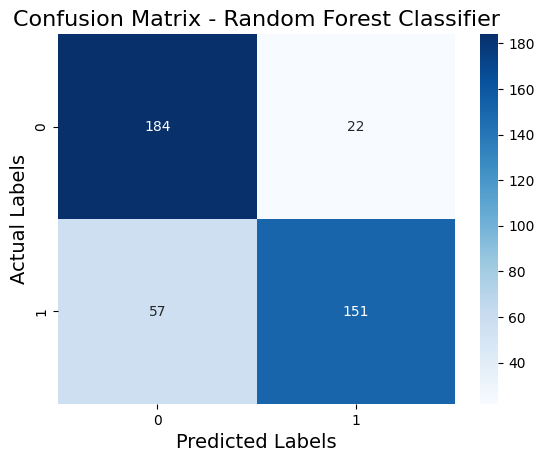

In [106]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_predR are already defined from your RandomForest prediction
cm3 = confusion_matrix(y_test, y_predR)

# Create a heatmap
ax = plt.subplot()

# If you still want to use a style, try 'ggplot' or 'seaborn-notebook' (check available styles first)
# plt.style.use('ggplot')  # Or use 'seaborn-notebook', etc.

# Plot the confusion matrix using seaborn heatmap
sn.heatmap(cm3, annot=True, fmt='g', cmap='Blues')

# Add labels and title
ax.set_xlabel('Predicted Labels', size=14)
ax.set_ylabel('Actual Labels', size=14)
ax.set_title('Confusion Matrix - Random Forest Classifier', size=16)

# Save and show the plot
plt.savefig('2-confusion_matrix_rftc.jpg', bbox_inches='tight', transparent=True)
plt.show()


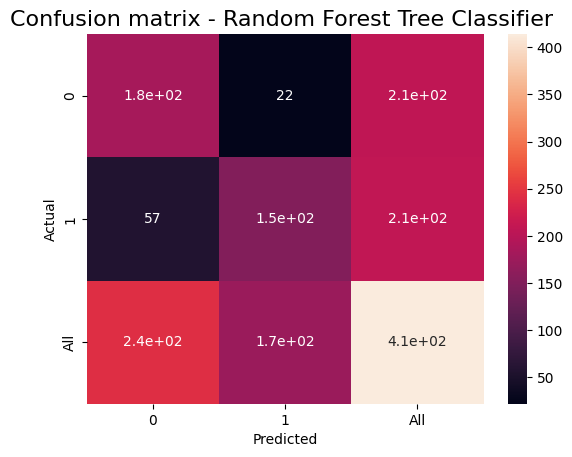

In [107]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
ax= plt.subplot()
confusion_matrix = pd.crosstab(y_test,y_predR, rownames=['Actual'], colnames=['Predicted'], margins = True)
ax.set_title('Confusion matrix - Random Forest Tree Classifier ', size=16)
sn.heatmap(confusion_matrix, annot=True)
plt.savefig('3-confusion matrix rftc.jpg',bbox_inches = 'tight',transparent=True)
plt.show()

0.8817681105302464


<ipython-input-108-d920beb01f04>:14: UserWarning: Legend does not support handles for float64 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend([auc],['roc_acu_score ='])


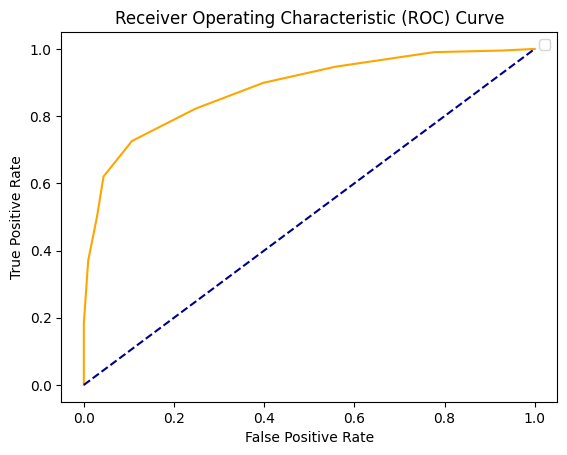

In [108]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

probs = model.predict_proba(X_test)
probs = probs[:, 1]
fper, tper, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test,probs)
print(auc)
plt.plot(fper, tper, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend([auc],['roc_acu_score ='])
plt.savefig('roc curve rftc.jpg',bbox_inches = 'tight',transparent=True)
plt.show()

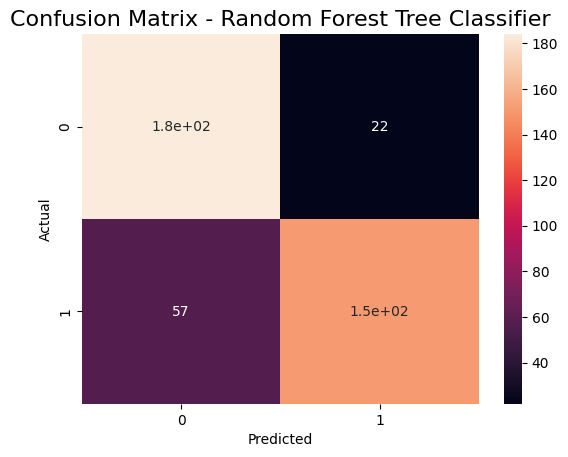

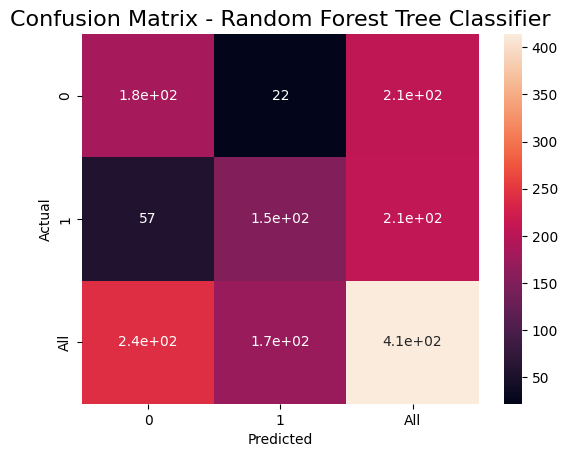

0.8817681105302464


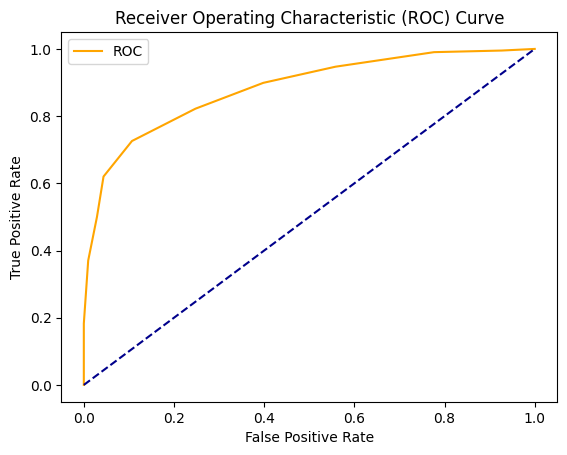

In [109]:
name = 'Random Forest Tree Classifier'
printer(name)

In [110]:

# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
model = classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
from sklearn.metrics import accuracy_score
score_gnb = accuracy_score(y_test,y_pred)

print(score_gnb)
print(cm)

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
my_pipeline = make_pipeline(imputer, GaussianNB())

from sklearn.model_selection import cross_val_score
scores = cross_val_score(my_pipeline, X, y, scoring='neg_mean_absolute_error')
print(scores)
print('Mean Absolute Error %2f' %(-1 * scores.mean()))


# classification report for precision, recall f1-score and accuracy
from sklearn.metrics import classification_report
matrix = classification_report(y_test,y_pred,labels=[1,0])
print('Classification report : \n',matrix)

0.7391304347826086
[[148  58]
 [ 50 158]]
[-0.27536232 -0.25603865 -0.31961259 -0.2251816  -0.33898305]
Mean Absolute Error 0.283036
Classification report : 
               precision    recall  f1-score   support

           1       0.73      0.76      0.75       208
           0       0.75      0.72      0.73       206

    accuracy                           0.74       414
   macro avg       0.74      0.74      0.74       414
weighted avg       0.74      0.74      0.74       414



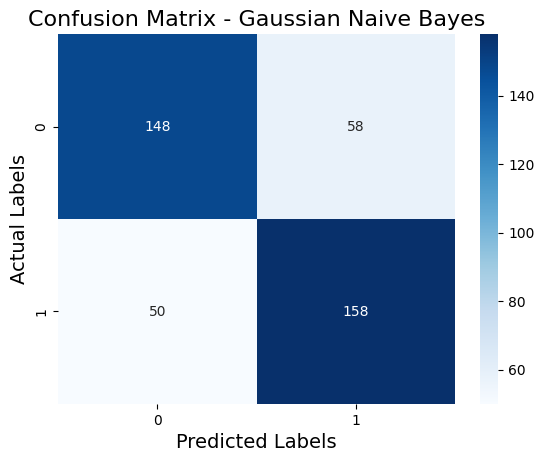

In [111]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred are already defined from your Gaussian Naive Bayes prediction
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap
ax = plt.subplot()

# Plot the confusion matrix using seaborn heatmap
sn.heatmap(cm, annot=True, fmt='g', cmap='Blues')

# Add labels and title
ax.set_xlabel('Predicted Labels', size=14)
ax.set_ylabel('Actual Labels', size=14)
ax.set_title('Confusion Matrix - Gaussian Naive Bayes', size=16)

# Save and show the plot
plt.savefig('2-confusion_matrix_Gaussian_Naive_Bayes.jpg', bbox_inches='tight', transparent=True)
plt.show()


0.7498599701269604


<ipython-input-112-d5e256fe1cd8>:14: UserWarning: Legend does not support handles for float64 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend([auc],['roc_acu_score ='])


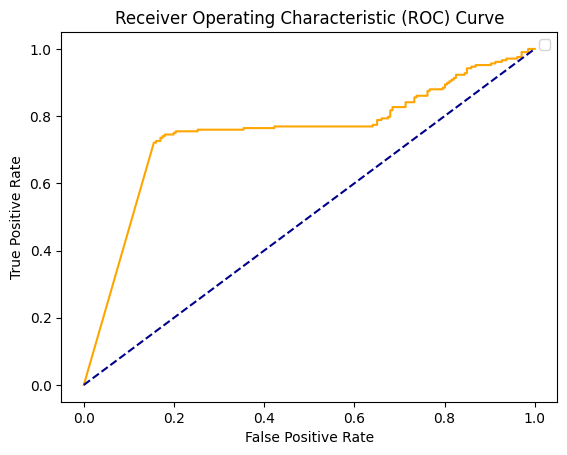

In [112]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

probs = model.predict_proba(X_test)
probs = probs[:, 1]
fper, tper, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test,probs)
print(auc)
plt.plot(fper, tper, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend([auc],['roc_acu_score ='])
plt.savefig('roc curve gnb.jpg',bbox_inches = 'tight',transparent=True)
plt.show()

In [113]:
from sklearn.neighbors import KNeighborsClassifier
classifier4 = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
model = classifier4.fit(X_train, y_train)

# Predicting the Test set results
y_predK = classifier4.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm4 = confusion_matrix(y_test, y_predK)
from sklearn.metrics import accuracy_score
score_knn = accuracy_score(y_test,y_predK)

print(score_knn)
print(cm4)

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
my_pipeline = make_pipeline(imputer, KNeighborsClassifier())

from sklearn.model_selection import cross_val_score
scores = cross_val_score(my_pipeline, X, y, scoring='neg_mean_absolute_error')
print(scores)
print('Mean Absolute Error %2f' %(-1 * scores.mean()))


# classification report for precision, recall f1-score and accuracy
from sklearn.metrics import classification_report
matrix = classification_report(y_test,y_predK,labels=[1,0])
print('Classification report : \n',matrix)

0.785024154589372
[[152  54]
 [ 35 173]]
[-0.20048309 -0.16425121 -0.18159806 -0.17675545 -0.23002421]
Mean Absolute Error 0.190622
Classification report : 
               precision    recall  f1-score   support

           1       0.76      0.83      0.80       208
           0       0.81      0.74      0.77       206

    accuracy                           0.79       414
   macro avg       0.79      0.78      0.78       414
weighted avg       0.79      0.79      0.78       414



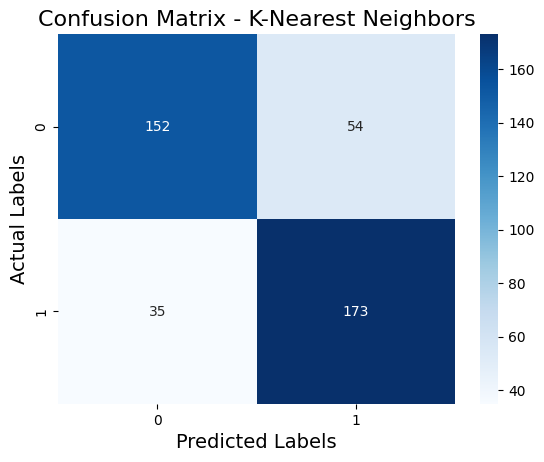

In [114]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_predK are already defined from your K-Nearest Neighbors prediction
cm4 = confusion_matrix(y_test, y_predK)

# Create a heatmap
ax = plt.subplot()

# Plot the confusion matrix using seaborn heatmap
sn.heatmap(cm4, annot=True, fmt='g', cmap='Blues')

# Add labels and title
ax.set_xlabel('Predicted Labels', size=14)
ax.set_ylabel('Actual Labels', size=14)
ax.set_title('Confusion Matrix - K-Nearest Neighbors', size=16)

# Save and show the plot
plt.savefig('2-confusion_matrix_K-Nearest_Neighbors.jpg', bbox_inches='tight', transparent=True)
plt.show()


0.8690020537714712


<ipython-input-115-336aebc11f32>:14: UserWarning: Legend does not support handles for float64 instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend([auc],['roc_acu_score ='])


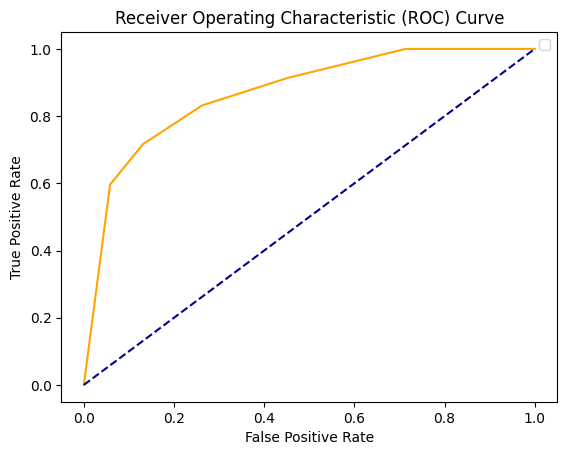

In [115]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

probs = model.predict_proba(X_test)
probs = probs[:, 1]
fper, tper, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test,probs)
print(auc)
plt.plot(fper, tper, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend([auc],['roc_acu_score ='])
plt.savefig('roc curve K-Nearest Neighbour.jpg',bbox_inches = 'tight',transparent=True)
plt.show()

<function sklearn.metrics._classification.accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)>